In [1]:
breeds = ['automatics', 'grunade_launcher', 'handgun', 'machine_guns', 'sniper']

In [2]:
import tensorflow as tf

In [3]:
args = {
    "labels": "inferred",
    "label_mode": "categorical",
    "batch_size": 32,
    "image_size": (256, 256),
    "seed": 1,
    "validation_split": .2,
    "class_names": breeds
}

In [4]:
train = tf.keras.utils.image_dataset_from_directory(
    "images",
    subset="training",
    **args
)

test = tf.keras.utils.image_dataset_from_directory(
  "images",
  subset="validation",
    **args
)

Found 46 files belonging to 5 classes.
Using 37 files for training.
Found 46 files belonging to 5 classes.
Using 9 files for validation.


In [5]:
train

<BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [6]:
first = train.take(1)
first

<TakeDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 5), dtype=tf.float32, name=None))>

In [7]:
images, labels = list(first)[0]
first_image = images[0]

In [8]:
first_image[:3,:3,0]

<tf.Tensor: shape=(3, 3), dtype=float32, numpy=
array([[253., 253., 253.],
       [253., 253., 253.],
       [253., 253., 253.]], dtype=float32)>

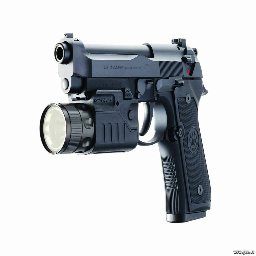

In [9]:
from PIL import Image

Image.fromarray(images[0].numpy().astype("uint8"))

In [10]:
print(labels[0])

tf.Tensor([0. 0. 1. 0. 0.], shape=(5,), dtype=float32)


In [11]:
train = train.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test = test.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [12]:
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential

model = Sequential([
  tf.keras.layers.Rescaling(1./255),
  layers.Conv2D(16, 3, padding='same', activation='relu', input_shape=(256,256,3)),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(breeds))
])

In [13]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [14]:
history = model.fit(
    train,
    validation_data=test,
    epochs=5,
    verbose=1
)

Epoch 1/5
2/2 [==============================] - 7s 2s/step - loss: 55.0140 - accuracy: 0.1892 - val_loss: 66.2559 - val_accuracy: 0.1111
Epoch 2/5
2/2 [==============================] - 2s 928ms/step - loss: 43.2086 - accuracy: 0.4865 - val_loss: 75.7032 - val_accuracy: 0.2222
Epoch 3/5
2/2 [==============================] - 2s 884ms/step - loss: 79.6987 - accuracy: 0.3514 - val_loss: 78.8642 - val_accuracy: 0.1111
Epoch 4/5
2/2 [==============================] - 2s 876ms/step - loss: 79.0378 - accuracy: 0.4865 - val_loss: 35.1007 - val_accuracy: 0.4444
Epoch 5/5
2/2 [==============================] - 2s 706ms/step - loss: 40.6398 - accuracy: 0.7297 - val_loss: 121.6682 - val_accuracy: 0.1111


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 256, 256, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      448       
                                                                 
 flatten (Flatten)           (None, 1048576)           0         
                                                                 
 dense (Dense)               (None, 128)               134217856 
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                                 
Total params: 134,218,949
Trainable params: 134,218,949
Non-trainable params: 0
_________________________________________________________________


<AxesSubplot:>

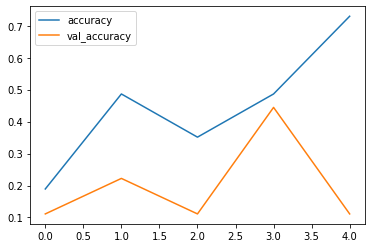

In [16]:
import pandas as pd

history_df = pd.DataFrame.from_dict(history.history)
history_df[["accuracy", "val_accuracy"]].plot()

In [17]:
def train_model(network, epochs=5):
    model = Sequential(network)

    model.compile(optimizer='adam',
                  loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
                  metrics=['accuracy'])

    history = model.fit(
      train,
      validation_data=test,
      epochs=epochs
    )
    history_df = pd.DataFrame.from_dict(history.history)
    return history_df, model

In [18]:
network = [
  tf.keras.layers.Rescaling(1./255),
  layers.Conv2D(16, 4, padding='same', activation='relu', input_shape=(256,256,3)),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 4, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2),
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(len(breeds))
]

history_df, model = train_model(network)

Epoch 1/5
2/2 [==============================] - 3s 582ms/step - loss: 3.9791 - accuracy: 0.1622 - val_loss: 5.6504 - val_accuracy: 0.1111
Epoch 2/5
2/2 [==============================] - 2s 433ms/step - loss: 2.6573 - accuracy: 0.4865 - val_loss: 1.9363 - val_accuracy: 0.1111
Epoch 3/5
2/2 [==============================] - 2s 411ms/step - loss: 1.8664 - accuracy: 0.1081 - val_loss: 1.7214 - val_accuracy: 0.1111
Epoch 4/5
2/2 [==============================] - 2s 399ms/step - loss: 1.6437 - accuracy: 0.1081 - val_loss: 1.7849 - val_accuracy: 0.1111
Epoch 5/5
2/2 [==============================] - 2s 423ms/step - loss: 1.5288 - accuracy: 0.1622 - val_loss: 3.0466 - val_accuracy: 0.1111


<AxesSubplot:>

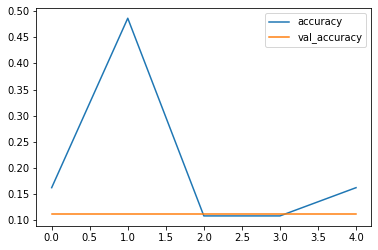

In [19]:
history_df[["accuracy", "val_accuracy"]].plot()

In [20]:
data_augmentation = tf.keras.Sequential(
  [
    layers.RandomFlip("horizontal", seed=1),
      layers.RandomRotation(0.2, seed=1),
    layers.RandomZoom(0.2, seed=1),
  ]
)


full_network = [
    data_augmentation
] + network

history_df, model = train_model(full_network, epochs=10)

Epoch 1/10
2/2 [==============================] - 4s 739ms/step - loss: 1.6680 - accuracy: 0.4054 - val_loss: 1.7073 - val_accuracy: 0.2222
Epoch 2/10
2/2 [==============================] - 2s 538ms/step - loss: 1.6135 - accuracy: 0.1622 - val_loss: 2.0565 - val_accuracy: 0.2222
Epoch 3/10
2/2 [==============================] - 3s 516ms/step - loss: 1.5914 - accuracy: 0.1351 - val_loss: 2.4490 - val_accuracy: 0.2222
Epoch 4/10
2/2 [==============================] - 2s 488ms/step - loss: 1.5794 - accuracy: 0.1892 - val_loss: 2.6270 - val_accuracy: 0.1111
Epoch 5/10
2/2 [==============================] - 3s 497ms/step - loss: 1.4952 - accuracy: 0.4865 - val_loss: 2.5495 - val_accuracy: 0.1111
Epoch 6/10
2/2 [==============================] - 2s 466ms/step - loss: 1.3496 - accuracy: 0.5135 - val_loss: 2.6507 - val_accuracy: 0.1111
Epoch 7/10
2/2 [==============================] - 2s 527ms/step - loss: 1.3213 - accuracy: 0.4865 - val_loss: 3.0406 - val_accuracy: 0.1111
Epoch 8/10
2/2 [====

<AxesSubplot:>

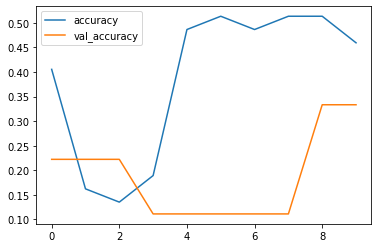

In [21]:

history_df[["accuracy", "val_accuracy"]].plot()

In [22]:
preds = model.predict(test)

1/1 [==============================] - 0s 261ms/step


In [23]:
import numpy as np
predicted_class = np.argmax(preds, axis=1)

In [24]:
actual_labels = np.concatenate([y for x, y in test], axis=0)

In [25]:
import itertools

actual_image = [x.numpy().astype("uint8") for x, y in test]
actual_image = list(itertools.chain.from_iterable(actual_image))
actual_image = [Image.fromarray(a) for a in actual_image]

In [26]:
actual_class = np.argmax(actual_labels, axis=1)

In [27]:
pred_df = pd.DataFrame(zip(predicted_class, actual_class, actual_image), columns=["prediction", "actual", "image"])


In [28]:
pred_df["prediction"] = pred_df["prediction"].apply(lambda x: breeds[x])
pred_df["actual"] = pred_df["actual"].apply(lambda x: breeds[x])

,prediction,actual,image
0,sniper,sniper,
1,automatics,grunade_launcher,
2,handgun,machine_guns,
3,automatics,grunade_launcher,
4,automatics,grunade_launcher,
5,handgun,grunade_launcher,
6,handgun,handgun,
7,automatics,grunade_launcher,
8,automatics,automatics,

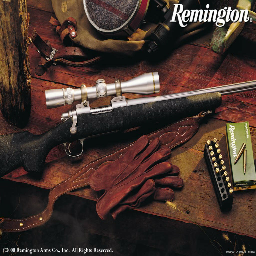
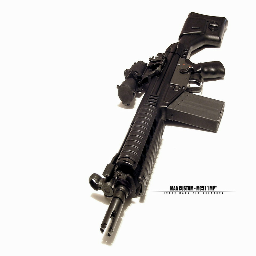
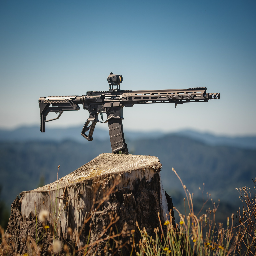
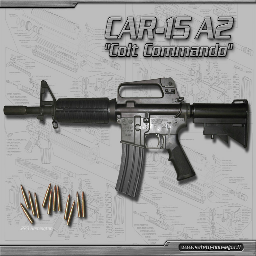
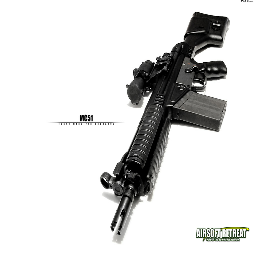
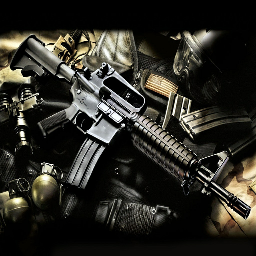
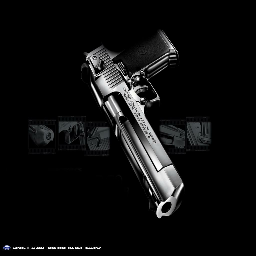
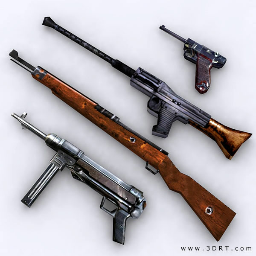
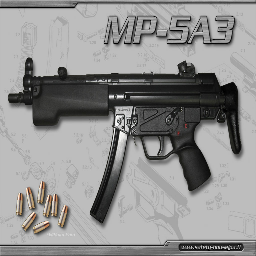

In [29]:
import base64
import io

def image_formatter(img):
    with io.BytesIO() as buffer:
        img.save(buffer, 'png')
        img_str = base64.b64encode(buffer.getvalue()).decode()
        return f'<img src="data:image/jpeg;base64,{img_str}">'

pred_df.head(10).style.format({'image': image_formatter})